# License

In [ ]:
# Copyright 2021 University of San Andres' Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2021 University of San Andres
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Clasificador de razas de perros

In [ ]:
%load_ext tensorboard

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


In [ ]:
gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

print('Num GPU available:', len(gpu_devices))

Num GPU available: 1


In [ ]:
import tensorflow_datasets as tfds

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

--2022-04-22 17:55:55--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.0
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  17.3MB/s    in 65s     

2022-04-22 17:57:01 (16.5 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [ ]:
!unzip -q dogImages.zip

from struct import unpack
from tqdm import tqdm
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break


bads = []

for dirName, subdirList, fileList in os.walk('dogImages'):
    imagesList = fileList
    for img in tqdm(imagesList):
      image = os.path.join(dirName,img)
      image = JPEG(image) 
      try:
        image.decode()   
      except:
        bads.append(img)
        print(dirName, img)
        os.remove(os.path.join(dirName,img))

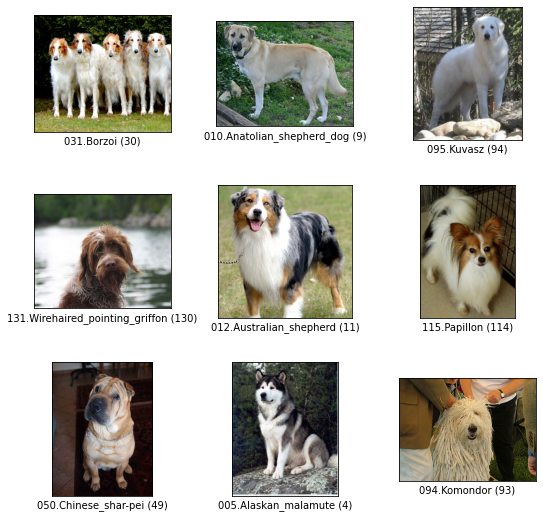

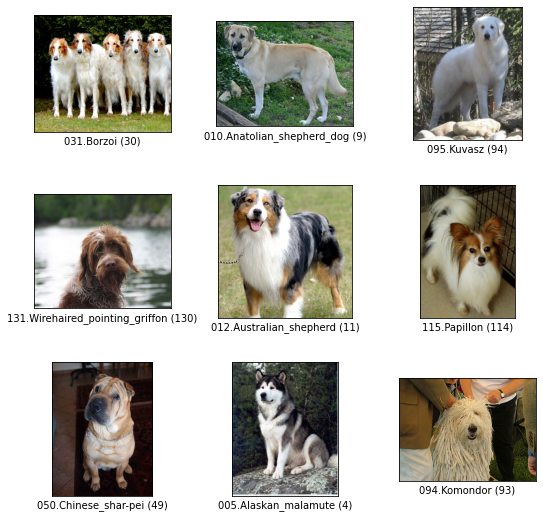

In [114]:
builder = tfds.ImageFolder('dogImages')
train, valid, test = builder.as_dataset(split=['train', 'valid', 'test'], shuffle_files=True, as_supervised=True)

tfds.show_examples(train, builder.info)

In [115]:
len(train)

6659

In [116]:
len(valid)

832

In [117]:
len(test)

832

(321, 350, 3)


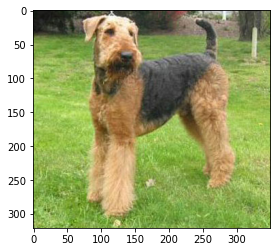

In [157]:
image, _ = next(iter(train))
_ = plt.imshow(image)

print(image.shape)

(258, 258, 3)


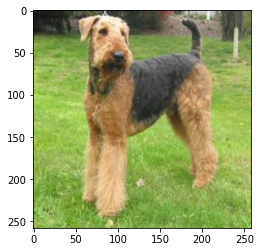

In [158]:
resize_and_rescale = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(258, 258),
    tf.keras.layers.Rescaling(1 / 255.0),
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(10),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.CenterCrop(224, 224),
    tf.keras.layers.Normalization(mean=[0.5, 0.5, 0.5], variance=[0.5, 0.5, 0.5]),
])

result = resize_and_rescale(image)
_ = plt.imshow(result)

print(result.shape)


(-0.5, 223.5, 223.5, -0.5)

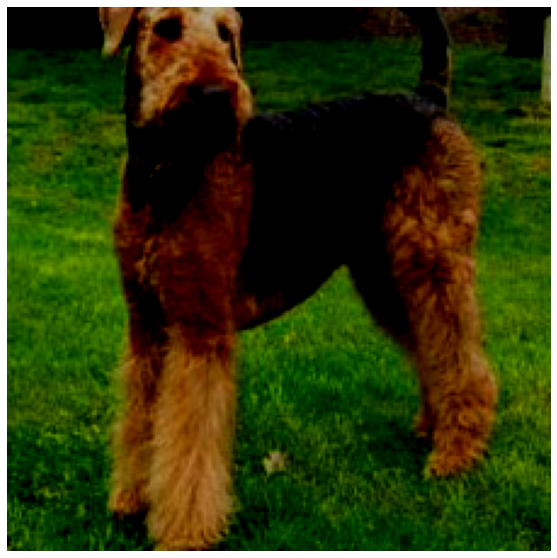

In [159]:

plt.figure(figsize=(10, 10))

result = tf.cast(tf.expand_dims(result, 0), tf.float32)

augmented_image = data_augmentation(result)
plt.imshow(augmented_image[0])
plt.axis("off")

In [135]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train, shuffle=True, augment=True)
#val_ds = prepare(valid)
#test_ds = prepare(test)

for i, _ in train_ds.take(1):
    print(i[0].shape)

(224, 224, 3)


In [136]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(133),
    tf.keras.layers.Dropout(0.5),
])

In [137]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [138]:
print(model.summary())

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 28, 28, 256)    

In [139]:
model.fit(train_ds, epochs=25)

Epoch 1/25
185/209 [=========================>....] - ETA: 7s - loss: 4.8950 - accuracy: 0.0076

KeyboardInterrupt: ignored